In [1]:
#explore geo data in the /mnt/storage7//jody/tb_data_2022_08_19.csv
#created - 26.08.2022

from re import sub
from unittest import result
from icecream import ic
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import re
import os
import json
import subprocess
import itertools
from statistics import mean
import pandas as pd
import chart_studio.plotly as py
import plotly.offline as po
import plotly.express as px
import plotly.graph_objs as pg
import matplotlib.pyplot as plt
import pycountry_convert
%matplotlib inline

po.init_notebook_mode(connected = True)
from urllib.request import urlopen
import pycountry
from sklearn import preprocessing

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

import dash
import dash_leaflet as dl

import folium
# plotly-geo
# geopandas --upgrade
# shapely
# python_version_tuple
# chart_studio

In [2]:
#load and remove nan
csv_ = "/mnt/storage7//jody/tb_data_2022_08_19.csv"
df = pd.read_csv(csv_)
#df = df.dropna(subset=['country_code', 'geographic_source', 'sublineage']).reset_index(drop=True)
df = df.dropna(subset=['country_code']).reset_index(drop=True)

/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning:

Columns (12,15,16,17,19,20,47,48,49,51,53,54,56,57,58,59,62,63) have mixed types.Specify dtype option on import or set low_memory=False.



In [124]:
check_ = df[["country_code", "geographic_source"]].isna()
check_.value_counts()

country_code  geographic_source
False         False                43565
              True                  2131
dtype: int64

<h2>Creating 3 letter country code for graphing + adding who region info

In [4]:
#converting 2 letter country code to 3 letter
def country_code_conv(two_letter):
    name = pycountry_convert.country_alpha2_to_country_name(two_letter.upper(), cn_name_format="default")
    three_letter = pycountry_convert.country_name_to_country_alpha3(name, cn_name_format="default")

    return three_letter

df['country_3l_code'] = None
for i, e in enumerate(df['country_code']):
    df['country_3l_code'][i] =  country_code_conv(e)


#adding who region data to each country
csv_ = "/mnt/storage7/lwang/trial_tb_philippines/pipelines/Genomic_data_analysis/strain_analysis/Mixture_testing/who_region.csv"
df_ = pd.read_csv(csv_, header=0)

list_ = []
for x in df["country_3l_code"]:
    c = df_[df_["Code"]==x]["WHO region"].iloc[0] #list(x)[0] is the get data out of df format into a string

    list_.append(c)

df["who_region"] = list_

/tmp/ipykernel_70546/892608665.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<h2>Mixed infection

In [118]:
#histogram for country with different sample counts
country_sample = df.groupby(["geographic_source"]).count()
country_sample['geographic_source'] = country_sample.index

df = px.data.tips()
fig = px.histogram(country_sample, x="wgs_id", nbins=100, title='Histogram of sample count of each country',labels={'wgs_id':'infection sample from each country'})
fig.show()

#count of country in terms of sample
# country_sample.shape
# country_sample[country_sample["wgs_id"]<3].shape

In [5]:
# create a column that indicate whether the sample has mixed infection 
# # no need for who region here
df['mixed_infection'] = "None"

for i, x in enumerate(df['sublineage']):
    len_ = len(str(x).split(";"))
    #if len_ > 1 and len_ < 3: #! not counting >2 mix infection
    if len_ > 1 : #! counting >2 mix infection
        df['mixed_infection'][i] = "Mixed_infection"
    else:
        df['mixed_infection'][i] = "Non-mixed_infection"


df_no_mix = df.loc[df["mixed_infection"]=="Non-mixed_infection"]
df_no_mix = df_no_mix.groupby(["country_3l_code"]).count()
df_no_mix['country_3l_code'] = df_no_mix.index

df_count = df.groupby(["country_3l_code"]).count()
df_count['country_3l_code'] = df_count.index

df_mix = df.loc[df["mixed_infection"]=="Mixed_infection"]
df_mix = df_mix.groupby(["country_3l_code"]).count()
df_mix['country_3l_code'] = df_mix.index

list_ = []
threshold = 10
for i, x in enumerate(df_count["country_3l_code"]):
    if x in df_mix["country_3l_code"]:
        mix = df_mix[df_mix['country_3l_code']==x]["mixed_infection"]
        all = df_count[df_count['country_3l_code']==x]["mixed_infection"]
        if int(all) <= threshold:
            list.append(0)
            continue
        ratio = int(mix) / int(all)
        list_.append(ratio)
    else:
        list_.append(0)

df_count["mix_rate"] = list_


/tmp/ipykernel_70546/1737055986.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_70546/1737055986.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
dict_ = {}
df_region = df.groupby(["who_region"]).count()
df_region["who_region"] = df_region.index

# for x in df["drug_resistance_type"].unique():
#     dict_[x] = []
#     df_dr = df[df["drug_resistance_type"]== x].groupby(["who_region"]).count()
#     df_dr["who_region"] = df_dr.index
#     for y in df_region["who_region"]:
#         if y in df_dr["who_region"]:
#             mix = df_dr[df_dr['who_region']==y]["drug_resistance_type"]
#             all = df_region[df_region["who_region"]==y]["drug_resistance_type"]
#             dict_[x].append(int(mix)/int(all)) #if country has sample with this resistance type, insert the ratio
#         else:            
#             dict_[x].append(0) #else insert 0
        
# for k, v in dict_.items():
#     df_region[k] = v

In [12]:
df['mixed_infection'].unique()

array(['Non-mixed_infection', 'Mixed_infection'], dtype=object)

In [13]:
no_mix = df[df['mixed_infection']=='Non-mixed_infection']
mix = df[df['mixed_infection']=='Mixed_infection']

In [14]:
no_mix = no_mix.groupby(["who_region"]).count()
no_mix["who_region"] = no_mix.index

mix = mix.groupby(["who_region"]).count()
mix["who_region"] = no_mix.index


In [19]:
mix['mixed_infection']/sum(mix['mixed_infection'],no_mix['mixed_infection'])

who_region
Africa                   0.015406
Americas                 0.009314
Eastern Mediterranean    0.007369
Europe                   0.006437
South-East Asia          0.014601
Western Pacific          0.010446
Name: mixed_infection, dtype: float64

In [132]:
df = px.data.tips()
fig = px.histogram(df_count, x="mix_rate", nbins=200, title='Histogram of rate of mixed infection recorded for countries',labels={'mixed_rate':'mixed infection sample number'})
fig.show()


In [134]:
fig = px.choropleth(df_count, color='mix_rate',
                    locations='country_3l_code',
                   )
fig.update_geos(fitbounds='locations', visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, dragmode = False)
fig.show()

<h2>Drug resistance type

In [ ]:
#previous verions calculating ratio of each type of resistance by country
# dict_ = {}
# for x in df["drug_resistance_type"].unique():
#     dict_[x] = []
#     df_dr = df[df["drug_resistance_type"]== x].groupby(["country_3l_code"]).count()
#     df_dr["country_3l_code"] = df_dr.index
#     for y in df_count["country_3l_code"]:
#         if y in df_dr["country_3l_code"]:
#             mix = df_dr[df_dr['country_3l_code']==y]["drug_resistance_type"]
#             all = df_count[df_count['country_3l_code']==y]["drug_resistance_type"]
#             dict_[x].append(int(mix)/int(all)) #if country has sample with this resistance type, insert the ratio
#         else:            
#             dict_[x].append(0) #else insert 0
            
# for k, v in dict_.items():
#     df_count[k] = v

In [12]:
#current version calculating ratio of eac type of resistance by who region
dict_ = {}
df_region = df.groupby(["who_region"]).count()
df_region["who_region"] = df_region.index

for x in df["drug_resistance_type"].unique():
    dict_[x] = []
    df_dr = df[df["drug_resistance_type"]== x].groupby(["who_region"]).count()
    df_dr["who_region"] = df_dr.index
    for y in df_region["who_region"]:
        if y in df_dr["who_region"]:
            mix = df_dr[df_dr['who_region']==y]["drug_resistance_type"]
            all = df_region[df_region["who_region"]==y]["drug_resistance_type"]
            dict_[x].append(int(mix)/int(all)) #if country has sample with this resistance type, insert the ratio
        else:            
            dict_[x].append(0) #else insert 0
        
for k, v in dict_.items():
    df_region[k] = v

df_region = df_region[["MDR-TB", "Pre-XDR-TB","HR-TB","Sensitive","Other","RR-TB","XDR-TB",]]
df_region_t = df_region.T
df_region_t["Drug resistance type"] = df_region_t.index

In [78]:
fig = px.choropleth(df, color='who_region',
                    locations='country_3l_code',color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_geos(fitbounds='locations', visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, dragmode = False)
fig.show()

In [85]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'MediumSeaGreen', 'blueViolet','DarkGray',"FireBrick"]
# colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
fig = go.Figure(data=[go.Pie(labels=input['Drug resistance type'], values=input["Africa"], textinfo='none',
                            insidetextorientation='radial'
                            )])
fig.update_traces(hoverinfo='label+percent', textinfo='none', textfont_size=20,
                marker=dict(colors=colors, line=dict(color='white', width=3)))  # color libpx.colors.qualitative.D3
fig.update(layout_title_text='Drug resistance for Africa')
fig.show()

In [62]:
fig = go.Figure(data=[go.Pie(labels=input['Drug resistance type'], values=input["Europe"], textinfo='none',
                            insidetextorientation='radial'
                            )])
fig.update_traces(hoverinfo='label+percent', textinfo='none', textfont_size=20,
                marker=dict(colors=colors, line=dict(color='white', width=3)))
fig.update(layout_title_text='Drug resistance for Europe')
fig.show()

In [61]:

fig = go.Figure(data=[go.Pie(labels=input['Drug resistance type'], values=input["Americas"], textinfo='none',
                            insidetextorientation='radial'
                            )])
fig.update_traces(hoverinfo='label+percent', textinfo='none', textfont_size=20,
            marker=dict(colors=colors, line=dict(color='white', width=3)))
fig.update(layout_title_text='Drug resistance for Americas')

fig.show()

In [60]:
fig = go.Figure(data=[go.Pie(labels=input['Drug resistance type'], values=input["Eastern Mediterranean"], textinfo='none',
                            insidetextorientation='radial'
                            )])
fig.update_traces(hoverinfo='label+percent', textinfo='none', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=3)))
fig.update(layout_title_text='Drug resistance for Eastern Mediterranean')

fig.show()

In [58]:
fig = go.Figure(data=[go.Pie(labels=input['Drug resistance type'], values=input["South-East Asia"], textinfo='none',
                            insidetextorientation='radial'
                            )])
fig.update_traces(hoverinfo='label+percent', textinfo='none', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=3)))
fig.update(layout_title_text='Drug resistance for South-East Asia')
fig.show()

In [59]:
fig = go.Figure(data=[go.Pie(labels=input['Drug resistance type'], values=input["Western Pacific"], textinfo='none',
                            insidetextorientation='radial'
                            )])
fig.update_traces(hoverinfo='label+percent', textinfo='none', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=3)))
fig.update(layout_title_text='Drug resistance for Western Pacific')

fig.show()

In [8]:
# fig = px.choropleth(df_count, color='MDR-TB',
#                     locations='country_3l_code',
#                     title="Automatic Labels Based on Data Frame Column Names"
#                    )
# fig.update_geos(fitbounds='locations', visible=False)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()image.png

In [9]:
# fig = px.choropleth(df_count, color='Pre-XDR-TB',
#                     locations='country_3l_code',
#                     title="Automatic Labels Based on Data Frame Column Names"
#                    )
# fig.update_geos(fitbounds='locations', visible=False)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [10]:
# fig = px.choropleth(df_count, color='Sensitive',
#                     locations='country_3l_code',
#                    )
# fig.update_geos(fitbounds='locations', visible=False)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [11]:
# fig = px.choropleth(df_count, color='Other',
#                     locations='country_3l_code',
#                    )
# fig.update_geos(fitbounds='locations', visible=False)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [12]:
# fig = px.choropleth(df_count, color='RR-TB',
#                     locations='country_3l_code',
#                    )
# fig.update_geos(fitbounds='locations', visible=False)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [13]:
# fig = px.choropleth(df_count, color='XDR-TB',
#                     locations='country_3l_code',
#                    )
# fig.update_geos(fitbounds='locations', visible=False)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

<h3>Create pie chart on geoplot

In [14]:
from geopy.geocoders import Nominatim

In [15]:
df.columns

Index(['wgs_id', 'mapped_reads', 'percent_mapped', 'median_depth',
       'missingness', 'main_lineage', 'sublineage', 'drug_resistance_type',
       'run_accession', 'sample_accession', 'accession', 'study_accession',
       'project_name', 'study_name', 'country_code', 'collection_date',
       'date_of_collection', 'patient_id', 'geographic_source', 'location',
       'country', 'rifampicin', 'isoniazid', 'ethambutol', 'pyrazinamide',
       'streptomycin', 'ofloxacin', 'moxifloxacin', 'levofloxacin', 'amikacin',
       'kanamycin', 'capreomycin', 'ciprofloxacin', 'prothionamide',
       'ethionamide', 'clarithromycin', 'clofazimine', 'bedaquiline',
       'cycloserine', 'linezolid', 'para-aminosalicylic_acid', 'rifabutin',
       'delamanid', 'host_body_site', 'environment_material', 'sample_alias',
       'sample_title', 'host_status', 'hiv_status', 'HIV_status',
       'first_public', 'host', 'id', 'host_sex', 'broker_name', 'tissue_type',
       'culture_collection', 'isolation_

In [48]:
df[["geographic_source","country_code","country_3l_code"]]

,geographic_source,country_code,country_3l_code
0,Portugal,pt,PRT
1,Portugal,pt,PRT
2,Portugal,pt,PRT
3,Portugal,pt,PRT
4,Portugal,pt,PRT
...,...,...,...
43469,Finland,fi,FIN
43470,Finland,fi,FIN
43471,Finland,fi,FIN
43472,Finland,fi,FIN


In [ ]:
geolocator = Nominatim(user_agent="catuserbot")
loc = geolocator.geocode(country)

In [24]:
df["country_code"]


0        pt
1        pt
2        pt
3        pt
4        pt
         ..
43469    fi
43470    fi
43471    fi
43472    fi
43473    fi
Name: country_code, Length: 43474, dtype: object

In [23]:
df

,wgs_id,mapped_reads,percent_mapped,median_depth,missingness,main_lineage,sublineage,drug_resistance_type,run_accession,sample_accession,...,isolation_source,strain,submitted_host_sex,center_name,host_tax_id,collected_by,isolate,description,country_3l_code,mixed_infection
0,ERR2864235,4385339,99.52,186,0.93,lineage2,lineage2.2.1,MDR-TB,ERR2864235,SAMEA5056353,...,NaN,NaN,NaN,NATIONAL INSTITUTE OF HEALTH DR. RICARDO JORGE,NaN,NaN,NaN,PT_TB0001,PRT,Non-mixed_infection
1,ERR2864288,3098879,99.76,132,1.35,lineage4,lineage4.3.4.2,MDR-TB,ERR2864288,SAMEA5056354,...,NaN,NaN,NaN,NATIONAL INSTITUTE OF HEALTH DR. RICARDO JORGE,NaN,NaN,NaN,PT_TB0002,PRT,Non-mixed_infection
2,ERR2864247,2158769,99.78,83,1.18,lineage4,lineage4.3.3,MDR-TB,ERR2864247,SAMEA5056355,...,NaN,NaN,NaN,NATIONAL INSTITUTE OF HEALTH DR. RICARDO JORGE,NaN,NaN,NaN,PT_TB0003,PRT,Non-mixed_infection
3,ERR2864239,2198316,99.86,98,1.24,lineage4,lineage4.3.4.2,MDR-TB,ERR2864239,SAMEA5056356,...,NaN,NaN,NaN,NATIONAL INSTITUTE OF HEALTH DR. RICARDO JORGE,NaN,NaN,NaN,PT_TB0004,PRT,Non-mixed_infection
4,ERR2864298,1190867,99.79,38,2.66,lineage4,lineage4.3.4.2,Pre-XDR-TB,ERR2864298,SAMEA5056432,...,NaN,NaN,NaN,NATIONAL INSTITUTE OF HEALTH DR. RICARDO JORGE,NaN,NaN,NaN,PT_TB0005,PRT,Non-mixed_infection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43469,ERR2503472,1820055,99.51,58,2.12,lineage2,lineage2.2.1,Sensitive,ERR2503472,SAMEA104685016,...,NaN,NaN,NaN,NATIONAL INSTITUTE FOR HEALTH AND WELFARE,NaN,NaN,NaN,TB WGS,FIN,Non-mixed_infection
43470,ERR2503473,2707753,99.61,87,1.37,lineage4,lineage4.1.2.1,Sensitive,ERR2503473,SAMEA104685017,...,NaN,NaN,NaN,NATIONAL INSTITUTE FOR HEALTH AND WELFARE,NaN,NaN,NaN,TB WGS,FIN,Non-mixed_infection
43471,ERR2503476,2179255,99.61,70,1.75,lineage4,lineage4.1.2,Sensitive,ERR2503476,SAMEA104685020,...,NaN,NaN,NaN,NATIONAL INSTITUTE FOR HEALTH AND WELFARE,NaN,NaN,NaN,TB WGS,FIN,Non-mixed_infection
43472,ERR2503478,974157,99.43,31,3.89,lineage1,lineage1.2.2.2,Sensitive,ERR2503478,SAMEA104685022,...,NaN,NaN,NaN,NATIONAL INSTITUTE FOR HEALTH AND WELFARE,NaN,NaN,NaN,TB WGS,FIN,Non-mixed_infection


In [26]:
df_count.index

Index(['AFG', 'AGO', 'AIA', 'ALB', 'ARG', 'AUS', 'AUT', 'AZE', 'BEL', 'BGD',
       ...
       'TUN', 'TUR', 'TZA', 'UGA', 'UKR', 'USA', 'UZB', 'VNM', 'ZAF', 'ZWE'],
      dtype='object', name='country_3l_code', length=112)

In [27]:
df_count1 = df.groupby(["country_code"]).count()
df_count["country_code"] = list(df_count1.index)

In [88]:
len(df_count["country_code"])

112

In [30]:
#2 letter code works better with folium, below generates country coordinates from 2 letter code
def geolocate(country):
    geolocator = Nominatim(user_agent="catuserbot")
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

list_ = []
for x in df_count["country_code"]:
    print(geolocate(x))
    list_.append(x)


(33.7680065, 66.2385139)
(18.1954947, -63.0750234)
(33.2588817, -86.8295337)
(47.59397, 14.12456)
(-34.9964963, -64.9672817)
(47.59397, 14.12456)
(-24.7761086, 134.755)
(40.3936294, 47.7872508)
(44.3053476, 17.5961467)
(24.4769288, 90.2934413)
(50.6402809, 4.6667145)
(42.6073975, 25.4856617)
(-17.0568696, -64.9912286)
(-10.3333333, -53.2)
(53.4250605, 27.6971358)
(61.0666922, -107.991707)
(-2.9814344, 23.8222636)
(-0.7264327, 15.6419155)
(46.7985624, 8.2319736)
(7.9897371, -5.5679458)
(-31.7613365, -71.3187697)
(4.6125522, 13.1535811)
(35.000074, 104.999927)
(4.099917, -72.9088133)
(16.0000552, -24.0083947)
(49.7439047, 15.3381061)
(51.1638175, 10.4478313)
(11.8145966, 42.8453061)
(55.670249, 10.3333283)
(19.0974031, -70.3028026)
(28.0000272, 2.9999825)
(58.7523778, 25.3319078)
(52.865196, -7.9794599)
(39.3260685, -4.8379791)
(10.2116702, 38.6521203)
(63.2467777, 25.9209164)
(46.603354, 1.8883335)
(-0.8999695, 11.6899699)
(54.7023545, -3.2765753)
(8.0300284, -1.0800271)
(77.6192349, -4

In [33]:
pip install mpl_toolkits

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits
Note: you may need to restart the kernel to use updated packages.


In [59]:
ratios=[0.4,0.3,0.3]
start = 0
x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
xy1 = zip(x,y)
xy = []
xy.append(xy1)

([<matplotlib.patches.Wedge at 0x7f207313ece0>,
 [Text(1.068035996798755, 0.26324724033138536, ''),
  Text(0.5111954611888796, 0.9740016429451692, ''),
  Text(-0.2632472778301652, 1.0680359875561347, ''),
  Text(-0.9740016549105622, 0.5111954383907257, ''),
  Text(-0.13259026373746033, -1.0919797717732829, ''),
  Text(1.0680360276074792, -0.26324711533545053, '')])

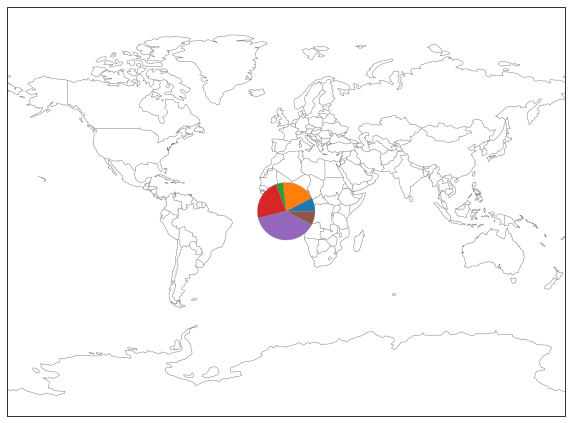

In [86]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# geological centre of Spain
lon, lat = (3.41, 40)

fig = plt.figure(figsize=(10,8))
proj = ccrs.Miller(central_longitude=0)
ax = fig.add_subplot(1,1,1, projection=proj)
ax.add_feature(cf.COASTLINE, lw=0.5, edgecolor='gray')
ax.add_feature(cf.BORDERS, lw=0.5, edgecolor='gray')
ax_sub = inset_axes(ax, width=1, height=1, loc=10, bbox_to_anchor=(lon, lat), bbox_transform=ax.transData)
ax_sub.pie([10, 25, 5, 30, 50, 10], wedgeprops={'edgecolor': 'gray','linewidth': 0.25})
# ax.set_extent((-20, 20, 20, 60), ccrs.Miller()) # (left, right, bottom, top)


In [77]:
m(4.5,50.5)

(244920.20618650576, 162472.17449697154)

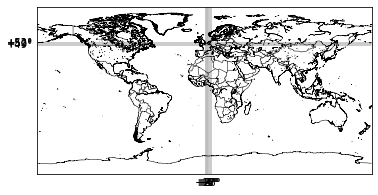

In [79]:
m = Basemap(resolution='i',projection='cyl', llcrnrlat=-90, urcrnrlat=90,llcrnrlon=-180, urcrnrlon=180,)
m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)



# X,Y = m(4.5,50.5)
# draw_pie(ax,[0.5,0.25,0.25], X, Y,size=300)

lon, lat = 4.5,50.5

ax_sub = inset_axes(ax, width=0.4, height=0.4, loc=10, bbox_to_anchor=(lon, lat), bbox_transform=ax.transData)
ax_sub.pie([10, 25, 5, 30, 50, 10], wedgeprops={'edgecolor': 'gray','linewidth': 0.25})
ax.set_extent((-20, 20, 20, 60), ccrs.Miller()) # (left, right, bottom, top)
plt.show()

# X,Y = m(5.5,50.8)
# draw_pie(ax,[0.20,0.18,0.62], X,Y, size=250)

In [63]:
for i, xyi in enumerate(xy):
    print(X)
    print(y)


244920.20618650576
[0, 0.0, 0.0021362788160164854, 0.0042725478827136025, 0.006408797450816476, 0.008545017771139215, 0.010681199094629409, 0.012817331672412618, 0.014953405755836856, 0.01708941159651709, 0.019225339446379733, 0.02136117955770711, 0.02349692218318198, 0.025632557575931966, 0.027768075989574096, 0.029903467678259247, 0.032038722896716616, 0.03417383190029823, 0.03630878494502338, 0.03844357228762311, 0.040578184185584676, 0.04271261089719601, 0.044846842681590185, 0.046980869798789855, 0.049114682509751706, 0.05124827107641092, 0.053381625761725594, 0.0555147368297212, 0.05764759454553499, 0.05978018917546045, 0.0619125109869917]


ic| xy1: <zip object at 0x7f20d94a6d00>
ic| i: 0
ic| xyi: <zip object at 0x7f206a37a740>
ic| [X]: [244920.20618650576]
ic| [y]: [[0,
           -1.0,
           -0.9985334138511238,
           -0.9941379571543597,
           -0.9868265225415263,
           -0.9766205557100867,
           -0.9635499925192229,
           -0.9476531711828026,
           -0.9289767198167915,
           -0.907575419670957,
           -0.8835120444460228,
           -0.8568571761675895,
           -0.8276889981568907,
           -0.7960930657056438,
           -0.7621620551276368,
           -0.7259954919231311,
           -0.6876994588534233,
           -0.6473862847818275,
           -0.6051742151937656,
           -0.5611870653623826,
           -0.5155538571770217,
           -0.4684084406997907,
           -0.41988910156026493,
           -0.3701381553399145,
           -0.3193015301359799,
           -0.26752833852922053,
           -0.21497044021102438,
           -0.16178199655276482,
           -0.1

TypeError: '<=' not supported between instances of 'zip' and 'int'

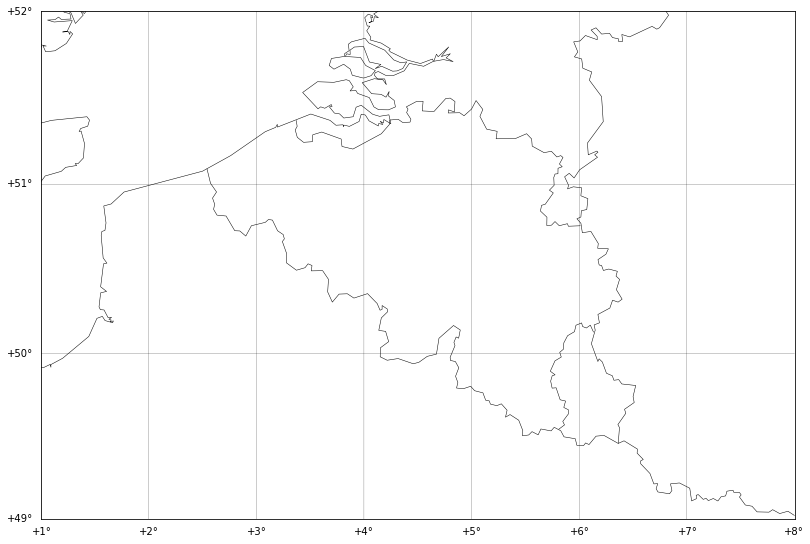

In [54]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

colors = ['red','blue','green','yellow','magenta','purple']

def draw_pie(ax,ratios=[0.4,0.3,0.3], X=0, Y=0, size = 1000):
    N = len(ratios)

    xy = []

    start = 0.
    for ratio in ratios:
        x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
        y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
        xy1 = zip(x,y)
        xy.append(xy1)
        start += ratio
    ic(xy1)
    for i, xyi in enumerate(xy):
        ic(i)
        ic(xyi)
        ic([X])
        ic([y])
        ax.scatter([X],[Y] , marker=(xyi,0), s=size, facecolor=colors[i] )

fig = plt.figure(figsize=(11.7,8.3))
#Custom adjust of the subplots
plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)
#Let's create a basemap around Belgium
m = Basemap(resolution='i',projection='merc', llcrnrlat=49.0,urcrnrlat=52.0,llcrnrlon=1.,urcrnrlon=8.0,lat_ts=51.0)
m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)

m.drawparallels(np.arange(49.,53.,1.),labels=[1,0,0,0],color='black',dashes=[1,0],labelstyle='+/-',linewidth=0.2) # draw parallels
m.drawmeridians(np.arange(1.,9.,1.),labels=[0,0,0,1],color='black',dashes=[1,0],labelstyle='+/-',linewidth=0.2) # draw meridians

X,Y = m(4.5,50.5)
draw_pie(ax,[0.5,0.25,0.25], X, Y,size=300)

X,Y = m(5.5,50.8)
draw_pie(ax,[0.20,0.18,0.62], X,Y, size=250)

plt.show()

ic| xy1: <zip object at 0x7f20ae2ea140>
ic| i: 0
ic| xyi: <zip object at 0x7f20ae303340>
ic| [X]: [4.5]
ic| [y]: [[0,
           -1.0,
           -0.9985334138511238,
           -0.9941379571543597,
           -0.9868265225415263,
           -0.9766205557100867,
           -0.9635499925192229,
           -0.9476531711828026,
           -0.9289767198167915,
           -0.907575419670957,
           -0.8835120444460228,
           -0.8568571761675895,
           -0.8276889981568907,
           -0.7960930657056438,
           -0.7621620551276368,
           -0.7259954919231311,
           -0.6876994588534233,
           -0.6473862847818275,
           -0.6051742151937656,
           -0.5611870653623826,
           -0.5155538571770217,
           -0.4684084406997907,
           -0.41988910156026493,
           -0.3701381553399145,
           -0.3193015301359799,
           -0.26752833852922053,
           -0.21497044021102438,
           -0.16178199655276482,
           -0.1081190184239424

TypeError: '<=' not supported between instances of 'zip' and 'int'

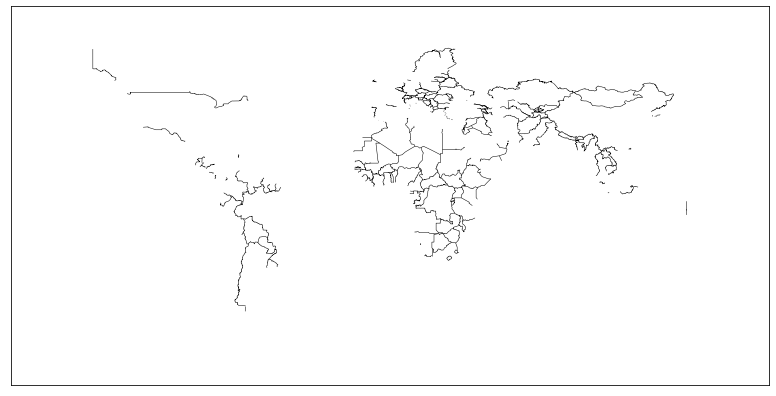

In [82]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(11.7,8.3))
#Custom adjust of the subplots
plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)
#Let's create a basemap around Belgium
m = Basemap(resolution='i',projection='cyl', llcrnrlat=-90, urcrnrlat=90,llcrnrlon=-180, urcrnrlon=180 )
m.drawcountries(linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)

# m.drawparallels(np.arange(49.,53.,1.),labels=[1,0,0,0],color='black',dashes=[1,0],labelstyle='+/-',linewidth=0.2) # draw parallels
# m.drawmeridians(np.arange(1.,9.,1.),labels=[0,0,0,1],color='black',dashes=[1,0],labelstyle='+/-',linewidth=0.2) # draw meridians

X,Y = m(4.5,50.5)
draw_pie(m,[0.5,0.25,0.25], X, Y,size=300)
draw_map(m)



/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



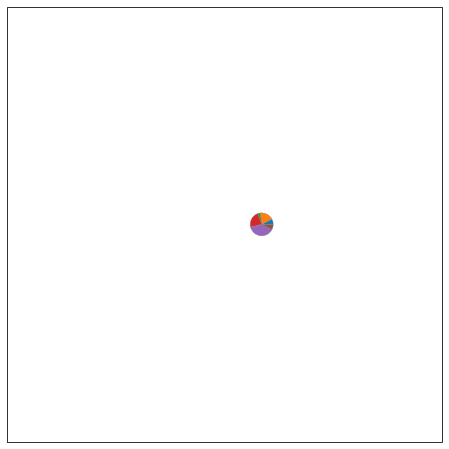

In [34]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# geological centre of Spain
lon, lat = (3.41, 40)

fig = plt.figure(figsize=(10,8))
proj = ccrs.Miller(central_longitude=0)
ax = fig.add_subplot(1,1,1, projection=proj)
ax.add_feature(cf.COASTLINE, lw=0.5, edgecolor='gray')
ax.add_feature(cf.BORDERS, lw=0.5, edgecolor='gray')
ax_sub = inset_axes(ax, width=0.4, height=0.4, loc=10, bbox_to_anchor=(lon, lat), bbox_transform=ax.transData)
ax_sub.pie([10, 25, 5, 30, 50, 10], wedgeprops={'edgecolor': 'gray','linewidth': 0.25})
ax.set_extent((-20, 20, 20, 60), ccrs.Miller()) # (left, right, bottom, top)
plt.show()